# The LSTM model

For this model, we used a Long Short Term Memory network from the Keras Python library to enhance our predictions.

## Library and data import

In [58]:
#Library imports
import re
import os
import time
import math
import random
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


#User Created functions
from eda_functions import *
from modeling_functions import *
from keras_wrapper_fix import Keras_Custom_Fitter

#Notebook arguments
%matplotlib inline

The following cell should be run only if running TensorFlow/Keras from a CUDA based GPU backend.

In [2]:
#Device specific gpu deterministic arguments
from tensorflow import config as tfconfig
physical_devices = tfconfig.list_physical_devices('GPU')
tfconfig.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

This cell will help in addressing the problem of neural network reproducibility.

In [3]:
#Sets random seeds to allow for reproducable results.
from tensorflow import random as tfrandom
SEED=127
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tfrandom.set_seed(SEED)

This dataset is obtained using the methodology provided in the notebook titled "bitcoin_data_gathering.ipynb"

In [4]:
btc=pd.read_pickle("data/bitcoin.pickle")

In [8]:
btc

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,NaN,1500520000
2013-04-29,134.44,147.49,134.00,144.54,NaN,1491160000
2013-04-30,144.00,146.93,134.05,139.00,NaN,1597780000
2013-05-01,139.00,139.89,107.72,116.99,NaN,1542820000
2013-05-02,116.38,125.60,92.28,105.21,NaN,1292190000
...,...,...,...,...,...,...
2020-05-01,8672.78,9048.02,8667.76,8864.77,4.406839e+10,162722652380
2020-05-02,8869.06,9007.19,8811.37,8988.60,4.013439e+10,165012307600
2020-05-03,8983.61,9167.78,8830.97,8897.47,4.710179e+10,163358189151


## Stationarity Check

Before running any models, we need to ensure that our data is stationary.

In [59]:
btc_log = np.log(btc)

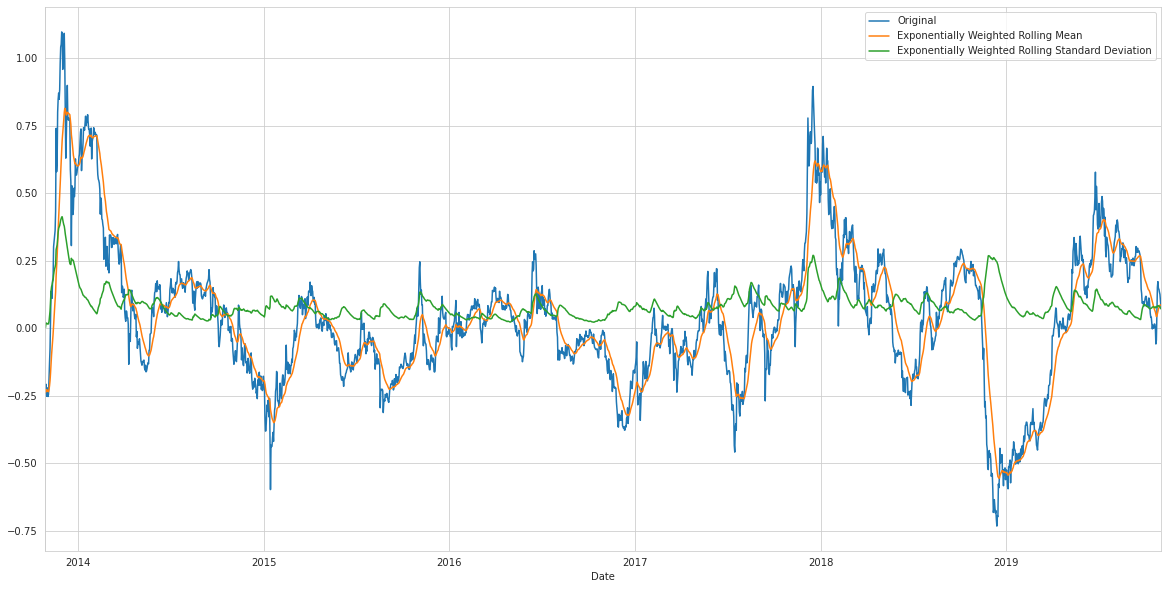

Test Statistic                   -3.919320
p-value                           0.001897
#Lags Used                       24.000000
Number of Observations Used    2173.000000
Critical Value (1%)              -3.433363
Critical Value (5%)              -2.862871
Critical Value (10%)             -2.567479
dtype: float64

In [46]:
stationarity_check(residual.dropna(), 8, figsize=(20, 10))

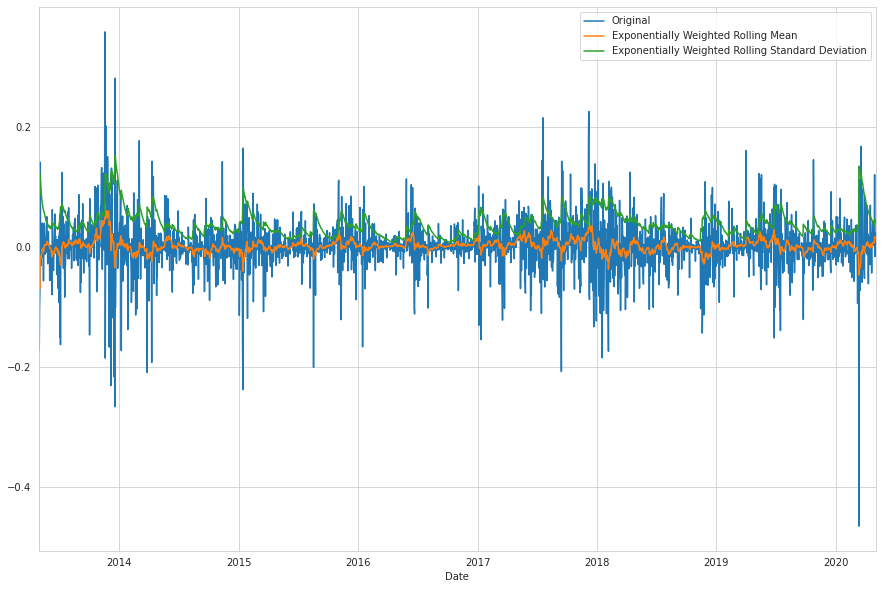

Test Statistic                -9.421022e+00
p-value                        5.502958e-16
#Lags Used                     2.200000e+01
Number of Observations Used    2.538000e+03
Critical Value (1%)           -3.432929e+00
Critical Value (5%)           -2.862679e+00
Critical Value (10%)          -2.567377e+00
dtype: float64

In [25]:
stationarity_check(btc_log.diff(1).dropna(), 8, figsize=(15, 10))

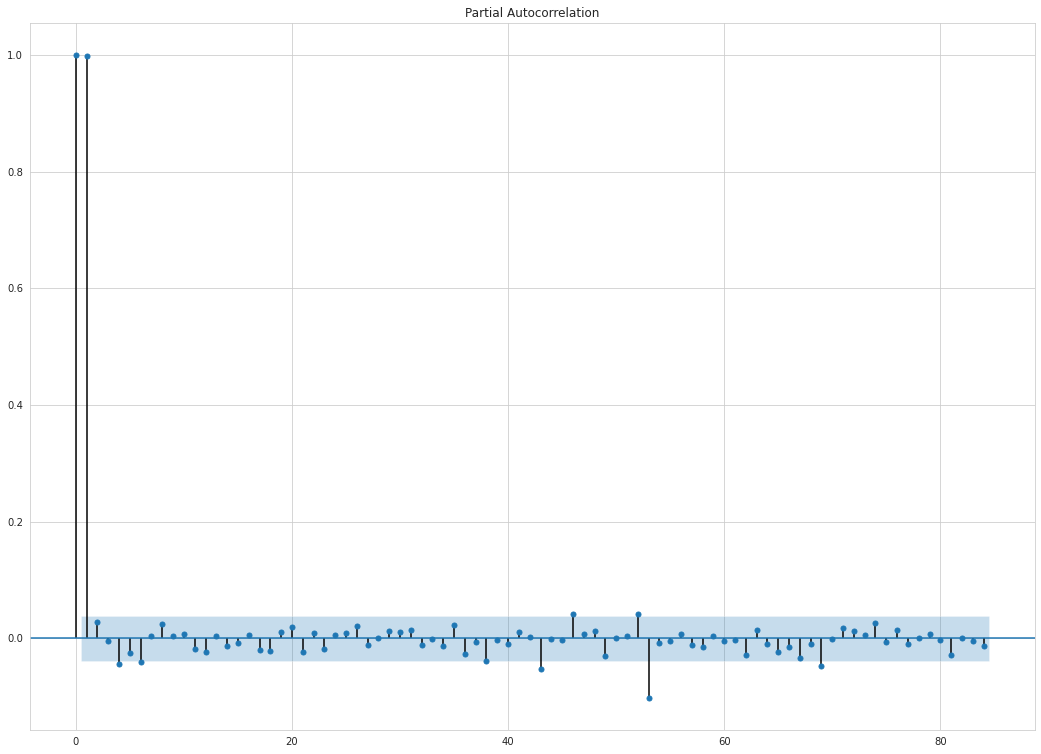

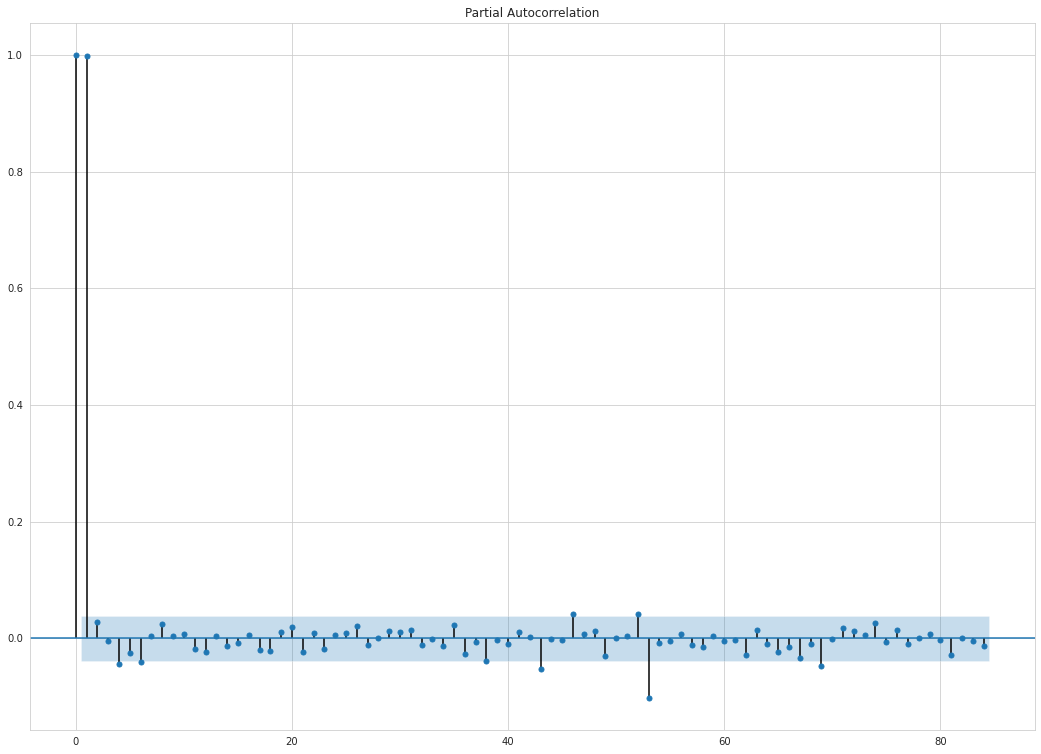

In [43]:
rcParams['figure.figsize'] = 18, 13
plot_pacf(btc_log, alpha=.05, lags=7*12)

In [ ]:
scaled_pipeline_2 = Pipeline([("scaler", StandardScaler()), ('RF', RandomForestClassifier(random_state=123))])

In [7]:
btc_log_train, btc_log_test = btc_log[:"2020-03-02"], btc_log["2020-03-03":]
btc_week_log_train, btc_week_log_test = btc_week_log[:"2020-03-02"], btc_week_log["2020-03-03":]

In [170]:
pdq_params = pdq_hyperparam_search(btc_week_log_train, 52, max_p=2, max_d=1, max_q=2)

ARIMA(0, 0, 0)x(0, 0, 0, 52)12 - rmse:7.277200584650921
ARIMA(0, 0, 0)x(0, 0, 1, 52)12 - rmse:4.964145709023613


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(0, 0, 2, 52)12 - rmse:5.288289673340116
ARIMA(0, 0, 0)x(0, 1, 0, 52)12 - rmse:2.4047407012351227


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(0, 1, 1, 52)12 - rmse:2.404620603974837


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(0, 0, 0)x(0, 1, 2, 52)12 - rmse:2.3988397137995547


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(1, 0, 0, 52)12 - rmse:2.359586794207256


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(1, 0, 1, 52)12 - rmse:2.361038622064176


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(1, 0, 2, 52)12 - rmse:2.843003741975424
ARIMA(0, 0, 0)x(1, 1, 0, 52)12 - rmse:2.403950627008218
ARIMA(0, 0, 0)x(1, 1, 1, 52)12 - rmse:2.41802391846093
ARIMA(0, 0, 0)x(1, 1, 2, 52)12 - rmse:2.431464699888556
ARIMA(0, 0, 0)x(2, 0, 0, 52)12 - rmse:2.4114980747274517


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(2, 0, 1, 52)12 - rmse:2.427892498844385
ARIMA(0, 0, 0)x(2, 0, 2, 52)12 - rmse:2.4844113599552786
ARIMA(0, 0, 0)x(2, 1, 0, 52)12 - rmse:2.412356341171035
ARIMA(0, 0, 0)x(2, 1, 1, 52)12 - rmse:2.40665050578462
ARIMA(0, 0, 0)x(2, 1, 2, 52)12 - rmse:2.3993998835267103
ARIMA(0, 0, 1)x(0, 0, 0, 52)12 - rmse:3.6853485129330035
ARIMA(0, 0, 1)x(0, 0, 1, 52)12 - rmse:3.1629208522288055


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(0, 0, 2, 52)12 - rmse:1084631861.0906034
ARIMA(0, 0, 1)x(0, 1, 0, 52)12 - rmse:2.2242339376337434


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(0, 1, 1, 52)12 - rmse:2.2259903072234875
ARIMA(0, 0, 1)x(0, 1, 2, 52)12 - rmse:2.258713956752682
ARIMA(0, 0, 1)x(1, 0, 0, 52)12 - rmse:2.2108702921995196
ARIMA(0, 0, 1)x(1, 0, 1, 52)12 - rmse:2.193995623027546


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(1, 0, 2, 52)12 - rmse:10.865442161820289
ARIMA(0, 0, 1)x(1, 1, 0, 52)12 - rmse:2.2242552699868625
ARIMA(0, 0, 1)x(1, 1, 1, 52)12 - rmse:2.2836891968805246
ARIMA(0, 0, 1)x(1, 1, 2, 52)12 - rmse:2.258515467892063
ARIMA(0, 0, 1)x(2, 0, 0, 52)12 - rmse:2.316240404736509
ARIMA(0, 0, 1)x(2, 0, 1, 52)12 - rmse:2.248064027000382


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(2, 0, 2, 52)12 - rmse:245995045.4026781
ARIMA(0, 0, 1)x(2, 1, 0, 52)12 - rmse:2.2796350095275955
ARIMA(0, 0, 1)x(2, 1, 1, 52)12 - rmse:2.2734826203793284
ARIMA(0, 0, 1)x(2, 1, 2, 52)12 - rmse:2.2660721853514896
ARIMA(0, 0, 2)x(0, 0, 0, 52)12 - rmse:1.9758079616264754
ARIMA(0, 0, 2)x(0, 0, 1, 52)12 - rmse:2.546745785343078
ARIMA(0, 0, 2)x(0, 0, 2, 52)12 - rmse:1213457188182.259
ARIMA(0, 0, 2)x(0, 1, 0, 52)12 - rmse:2.1782151173003514


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 2)x(0, 1, 1, 52)12 - rmse:2.1803729398288847
ARIMA(0, 0, 2)x(0, 1, 2, 52)12 - rmse:2.222079353101851
ARIMA(0, 0, 2)x(1, 0, 0, 52)12 - rmse:2.1722482104617042
ARIMA(0, 0, 2)x(1, 0, 1, 52)12 - rmse:2.1664522472225047


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 2)x(1, 0, 2, 52)12 - rmse:2912788980.6085443
ARIMA(0, 0, 2)x(1, 1, 0, 52)12 - rmse:2.2244560488125913
ARIMA(0, 0, 2)x(1, 1, 1, 52)12 - rmse:2.260971452264978
ARIMA(0, 0, 2)x(1, 1, 2, 52)12 - rmse:2.384774920775448
ARIMA(0, 0, 2)x(2, 0, 0, 52)12 - rmse:2.3367510192131173
ARIMA(0, 0, 2)x(2, 0, 1, 52)12 - rmse:2.2462407519295677


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 2)x(2, 0, 2, 52)12 - rmse:1234379200.1499202
ARIMA(0, 0, 2)x(2, 1, 0, 52)12 - rmse:2.2443898790210235


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 2)x(2, 1, 1, 52)12 - rmse:2.2415939011210577
ARIMA(0, 0, 2)x(2, 1, 2, 52)12 - rmse:2.2429746045362755
ARIMA(0, 1, 0)x(0, 0, 0, 52)12 - rmse:0.2764279602906454
ARIMA(0, 1, 0)x(0, 0, 1, 52)12 - rmse:0.27638043426979514
ARIMA(0, 1, 0)x(0, 0, 2, 52)12 - rmse:0.27795299494270614
ARIMA(0, 1, 0)x(0, 1, 0, 52)12 - rmse:0.34055643303189836
ARIMA(0, 1, 0)x(0, 1, 1, 52)12 - rmse:0.33537949867823613
ARIMA(0, 1, 0)x(0, 1, 2, 52)12 - rmse:0.3342217141724749
ARIMA(0, 1, 0)x(1, 0, 0, 52)12 - rmse:0.2764095100833285
ARIMA(0, 1, 0)x(1, 0, 1, 52)12 - rmse:0.27639839902101454


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 0)x(1, 0, 2, 52)12 - rmse:0.2787618040938389
ARIMA(0, 1, 0)x(1, 1, 0, 52)12 - rmse:0.31546311406403277
ARIMA(0, 1, 0)x(1, 1, 1, 52)12 - rmse:0.3257648712679098
ARIMA(0, 1, 0)x(1, 1, 2, 52)12 - rmse:0.32828347493801424
ARIMA(0, 1, 0)x(2, 0, 0, 52)12 - rmse:0.27654501000238
ARIMA(0, 1, 0)x(2, 0, 1, 52)12 - rmse:0.27655274644616384


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 0)x(2, 0, 2, 52)12 - rmse:0.2819820310124351
ARIMA(0, 1, 0)x(2, 1, 0, 52)12 - rmse:0.3140323645928871
ARIMA(0, 1, 0)x(2, 1, 1, 52)12 - rmse:0.31692086251604207
ARIMA(0, 1, 0)x(2, 1, 2, 52)12 - rmse:0.31470202544356607
ARIMA(0, 1, 1)x(0, 0, 0, 52)12 - rmse:0.2743796290415786
ARIMA(0, 1, 1)x(0, 0, 1, 52)12 - rmse:0.2754972794486327


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 1)x(0, 0, 2, 52)12 - rmse:0.27708113187472816
ARIMA(0, 1, 1)x(0, 1, 0, 52)12 - rmse:0.33827850511954005
ARIMA(0, 1, 1)x(0, 1, 1, 52)12 - rmse:0.33320591770758873
ARIMA(0, 1, 1)x(0, 1, 2, 52)12 - rmse:0.33348613940695565
ARIMA(0, 1, 1)x(1, 0, 0, 52)12 - rmse:0.2755281861357369
ARIMA(0, 1, 1)x(1, 0, 1, 52)12 - rmse:0.2755059099605017


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 1)x(1, 0, 2, 52)12 - rmse:0.27784698925606416
ARIMA(0, 1, 1)x(1, 1, 0, 52)12 - rmse:0.3137502884664071
ARIMA(0, 1, 1)x(1, 1, 1, 52)12 - rmse:0.3245043866543009
ARIMA(0, 1, 1)x(1, 1, 2, 52)12 - rmse:0.3261240602201556
ARIMA(0, 1, 1)x(2, 0, 0, 52)12 - rmse:0.2757355738289962
ARIMA(0, 1, 1)x(2, 0, 1, 52)12 - rmse:0.27571986743421595


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 1)x(2, 0, 2, 52)12 - rmse:0.2814253265429883
ARIMA(0, 1, 1)x(2, 1, 0, 52)12 - rmse:0.3129443519662844
ARIMA(0, 1, 1)x(2, 1, 1, 52)12 - rmse:0.31634800635900934
ARIMA(0, 1, 1)x(2, 1, 2, 52)12 - rmse:0.31414984223043446
ARIMA(0, 1, 2)x(0, 0, 0, 52)12 - rmse:0.2739559133656569
ARIMA(0, 1, 2)x(0, 0, 1, 52)12 - rmse:0.27536382852343083


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 2)x(0, 0, 2, 52)12 - rmse:0.2769267807037367
ARIMA(0, 1, 2)x(0, 1, 0, 52)12 - rmse:0.33787723130757336
ARIMA(0, 1, 2)x(0, 1, 1, 52)12 - rmse:0.33283947164566385
ARIMA(0, 1, 2)x(0, 1, 2, 52)12 - rmse:0.3334389493332408
ARIMA(0, 1, 2)x(1, 0, 0, 52)12 - rmse:0.2753931829562013
ARIMA(0, 1, 2)x(1, 0, 1, 52)12 - rmse:0.27537351550415484


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 2)x(1, 0, 2, 52)12 - rmse:0.2776980181512182
ARIMA(0, 1, 2)x(1, 1, 0, 52)12 - rmse:0.3131925734965698
ARIMA(0, 1, 2)x(1, 1, 1, 52)12 - rmse:0.32445757578336964
ARIMA(0, 1, 2)x(1, 1, 2, 52)12 - rmse:0.32540839542551886
ARIMA(0, 1, 2)x(2, 0, 0, 52)12 - rmse:0.2755792360682906
ARIMA(0, 1, 2)x(2, 0, 1, 52)12 - rmse:0.27560400840609656


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 2)x(2, 0, 2, 52)12 - rmse:0.2812467227425063
ARIMA(0, 1, 2)x(2, 1, 0, 52)12 - rmse:0.3129967280360902
ARIMA(0, 1, 2)x(2, 1, 1, 52)12 - rmse:0.315992815772518
ARIMA(0, 1, 2)x(2, 1, 2, 52)12 - rmse:0.3141735022945978
ARIMA(1, 0, 0)x(0, 0, 0, 52)12 - rmse:0.2762226553326686
ARIMA(1, 0, 0)x(0, 0, 1, 52)12 - rmse:0.2762838999283334


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(0, 0, 2, 52)12 - rmse:0.2821112756562569
ARIMA(1, 0, 0)x(0, 1, 0, 52)12 - rmse:0.7103711992967877


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(0, 1, 1, 52)12 - rmse:0.4156539846395375
ARIMA(1, 0, 0)x(0, 1, 2, 52)12 - rmse:0.41054207232144035
ARIMA(1, 0, 0)x(1, 0, 0, 52)12 - rmse:0.276328964768308


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(1, 0, 1, 52)12 - rmse:0.2768001659995624


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(1, 0, 2, 52)12 - rmse:0.353692056557786
ARIMA(1, 0, 0)x(1, 1, 0, 52)12 - rmse:0.42965531969772497


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(1, 1, 1, 52)12 - rmse:0.4275247476526721
ARIMA(1, 0, 0)x(1, 1, 2, 52)12 - rmse:0.39909413050127324
ARIMA(1, 0, 0)x(2, 0, 0, 52)12 - rmse:0.2770963611529232


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(2, 0, 1, 52)12 - rmse:0.2804754772927714


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(2, 0, 2, 52)12 - rmse:0.3700665149758099
ARIMA(1, 0, 0)x(2, 1, 0, 52)12 - rmse:0.3718375453312415


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(2, 1, 1, 52)12 - rmse:0.37205055861246344
ARIMA(1, 0, 0)x(2, 1, 2, 52)12 - rmse:0.37166898144654953
ARIMA(1, 0, 1)x(0, 0, 0, 52)12 - rmse:0.27427472195738833
ARIMA(1, 0, 1)x(0, 0, 1, 52)12 - rmse:0.2758680863535128


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(0, 0, 2, 52)12 - rmse:0.2809063296165334
ARIMA(1, 0, 1)x(0, 1, 0, 52)12 - rmse:0.7529229151643586


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(0, 1, 1, 52)12 - rmse:0.41420691849396735
ARIMA(1, 0, 1)x(0, 1, 2, 52)12 - rmse:0.4098654917733738
ARIMA(1, 0, 1)x(1, 0, 0, 52)12 - rmse:0.2755268571390916


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(1, 0, 1, 52)12 - rmse:0.2795941199074834


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(1, 0, 2, 52)12 - rmse:0.35174735092536497
ARIMA(1, 0, 1)x(1, 1, 0, 52)12 - rmse:0.42047202849448734


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(1, 1, 1, 52)12 - rmse:0.41704198154905525
ARIMA(1, 0, 1)x(1, 1, 2, 52)12 - rmse:0.3951574337653611
ARIMA(1, 0, 1)x(2, 0, 0, 52)12 - rmse:0.27634316472340476


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(2, 0, 1, 52)12 - rmse:0.28759464373100563


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(2, 0, 2, 52)12 - rmse:0.36938409812697953


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(2, 1, 0, 52)12 - rmse:0.37089304652617283


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(2, 1, 1, 52)12 - rmse:0.3712460771862685


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(2, 1, 2, 52)12 - rmse:0.37147769179260576
ARIMA(1, 0, 2)x(0, 0, 0, 52)12 - rmse:0.2738852850110645


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 2)x(0, 0, 1, 52)12 - rmse:0.27540493200515653


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 2)x(0, 0, 2, 52)12 - rmse:0.2811009056598044
ARIMA(1, 0, 2)x(0, 1, 0, 52)12 - rmse:0.800082285999489


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 2)x(0, 1, 1, 52)12 - rmse:0.4141815620990708
ARIMA(1, 0, 2)x(0, 1, 2, 52)12 - rmse:0.409784031216318


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 2)x(1, 0, 0, 52)12 - rmse:0.2754062149522184


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 2)x(1, 0, 1, 52)12 - rmse:0.2786336981570337


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 2)x(1, 0, 2, 52)12 - rmse:0.35205069505170816
ARIMA(1, 0, 2)x(1, 1, 0, 52)12 - rmse:0.41397533644362466


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 2)x(1, 1, 1, 52)12 - rmse:0.40004808757660215
ARIMA(1, 0, 2)x(1, 1, 2, 52)12 - rmse:0.39375191935264403
ARIMA(1, 0, 2)x(2, 0, 0, 52)12 - rmse:0.2762073251699352


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 2)x(2, 0, 1, 52)12 - rmse:0.28388715925591096


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 2)x(2, 0, 2, 52)12 - rmse:0.3697077224556186
ARIMA(1, 0, 2)x(2, 1, 0, 52)12 - rmse:0.37094307759349154


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 2)x(2, 1, 1, 52)12 - rmse:0.37704009415220324


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 2)x(2, 1, 2, 52)12 - rmse:0.37176641403709454
ARIMA(1, 1, 0)x(0, 0, 0, 52)12 - rmse:0.2795187059799801
ARIMA(1, 1, 0)x(0, 0, 1, 52)12 - rmse:0.277776734964507


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(0, 0, 2, 52)12 - rmse:0.2817549707022553
ARIMA(1, 1, 0)x(0, 1, 0, 52)12 - rmse:0.3377375943774038
ARIMA(1, 1, 0)x(0, 1, 1, 52)12 - rmse:0.33589327329072277
ARIMA(1, 1, 0)x(0, 1, 2, 52)12 - rmse:0.3346864944347282
ARIMA(1, 1, 0)x(1, 0, 0, 52)12 - rmse:0.27778861304712094
ARIMA(1, 1, 0)x(1, 0, 1, 52)12 - rmse:0.2777958595040559


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(1, 0, 2, 52)12 - rmse:0.2808705717944412
ARIMA(1, 1, 0)x(1, 1, 0, 52)12 - rmse:0.31910885376508497
ARIMA(1, 1, 0)x(1, 1, 1, 52)12 - rmse:0.32602821353695044
ARIMA(1, 1, 0)x(1, 1, 2, 52)12 - rmse:0.3271714608409063
ARIMA(1, 1, 0)x(2, 0, 0, 52)12 - rmse:0.27819339296539786
ARIMA(1, 1, 0)x(2, 0, 1, 52)12 - rmse:0.27819914054056927


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(2, 0, 2, 52)12 - rmse:0.28274693980659527
ARIMA(1, 1, 0)x(2, 1, 0, 52)12 - rmse:0.3155919702828094
ARIMA(1, 1, 0)x(2, 1, 1, 52)12 - rmse:0.3182773447740707
ARIMA(1, 1, 0)x(2, 1, 2, 52)12 - rmse:0.31598180416556154
ARIMA(1, 1, 1)x(0, 0, 0, 52)12 - rmse:0.28110514891175975
ARIMA(1, 1, 1)x(0, 0, 1, 52)12 - rmse:0.27991738025415813


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 1)x(0, 0, 2, 52)12 - rmse:0.282769085796339
ARIMA(1, 1, 1)x(0, 1, 0, 52)12 - rmse:0.33910868633900165
ARIMA(1, 1, 1)x(0, 1, 1, 52)12 - rmse:0.33516120333870786
ARIMA(1, 1, 1)x(0, 1, 2, 52)12 - rmse:0.3384348487862209
ARIMA(1, 1, 1)x(1, 0, 0, 52)12 - rmse:0.2794518942670648
ARIMA(1, 1, 1)x(1, 0, 1, 52)12 - rmse:0.2800091205922812


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 1)x(1, 0, 2, 52)12 - rmse:0.28337442966197407
ARIMA(1, 1, 1)x(1, 1, 0, 52)12 - rmse:0.3190825512978826
ARIMA(1, 1, 1)x(1, 1, 1, 52)12 - rmse:0.32734921953958673
ARIMA(1, 1, 1)x(1, 1, 2, 52)12 - rmse:0.3316625198924563
ARIMA(1, 1, 1)x(2, 0, 0, 52)12 - rmse:0.2808408765530499
ARIMA(1, 1, 1)x(2, 0, 1, 52)12 - rmse:0.2808768498279766


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 1)x(2, 0, 2, 52)12 - rmse:0.2861432193020887
ARIMA(1, 1, 1)x(2, 1, 0, 52)12 - rmse:0.3207300599260667
ARIMA(1, 1, 1)x(2, 1, 1, 52)12 - rmse:0.3228657035174541
ARIMA(1, 1, 1)x(2, 1, 2, 52)12 - rmse:0.3208612832890185
ARIMA(1, 1, 2)x(0, 0, 0, 52)12 - rmse:0.27659856496241164
ARIMA(1, 1, 2)x(0, 0, 1, 52)12 - rmse:0.27787171238573066
ARIMA(1, 1, 2)x(0, 0, 2, 52)12 - rmse:0.27853348968924585
ARIMA(1, 1, 2)x(0, 1, 0, 52)12 - rmse:0.33837415471947324
ARIMA(1, 1, 2)x(0, 1, 1, 52)12 - rmse:0.3328846960614504
ARIMA(1, 1, 2)x(0, 1, 2, 52)12 - rmse:0.3358153904516923
ARIMA(1, 1, 2)x(1, 0, 0, 52)12 - rmse:0.2772256186224709
ARIMA(1, 1, 2)x(1, 0, 1, 52)12 - rmse:0.2779814440903123
ARIMA(1, 1, 2)x(1, 0, 2, 52)12 - rmse:0.27921149636194653
ARIMA(1, 1, 2)x(1, 1, 0, 52)12 - rmse:0.34394331692901536
ARIMA(1, 1, 2)x(1, 1, 1, 52)12 - rmse:0.32523420737355535
ARIMA(1, 1, 2)x(1, 1, 2, 52)12 - rmse:0.3283127760727221
ARIMA(1, 1, 2)x(2, 0, 0, 52)12 - rmse:0.2770877842745049


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 2)x(2, 0, 1, 52)12 - rmse:0.27712700229734566


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 2)x(2, 0, 2, 52)12 - rmse:0.28238149663806317
ARIMA(1, 1, 2)x(2, 1, 0, 52)12 - rmse:0.3156414514966655
ARIMA(1, 1, 2)x(2, 1, 1, 52)12 - rmse:0.32020707582437485
ARIMA(1, 1, 2)x(2, 1, 2, 52)12 - rmse:0.3182034280966828
ARIMA(2, 0, 0)x(0, 0, 0, 52)12 - rmse:0.2926785594624612
ARIMA(2, 0, 0)x(0, 0, 1, 52)12 - rmse:0.28691711003245796


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 0)x(0, 0, 2, 52)12 - rmse:0.2981783784955761
ARIMA(2, 0, 0)x(0, 1, 0, 52)12 - rmse:0.8055803105642134


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 0)x(0, 1, 1, 52)12 - rmse:0.4008451958423546
ARIMA(2, 0, 0)x(0, 1, 2, 52)12 - rmse:0.3967227848487989
ARIMA(2, 0, 0)x(1, 0, 0, 52)12 - rmse:0.28641322822706006


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 0)x(1, 0, 1, 52)12 - rmse:0.29046848091539884


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 0)x(1, 0, 2, 52)12 - rmse:0.37653980590803676
ARIMA(2, 0, 0)x(1, 1, 0, 52)12 - rmse:0.40204604856927756


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 0)x(1, 1, 1, 52)12 - rmse:0.39451906498986294
ARIMA(2, 0, 0)x(1, 1, 2, 52)12 - rmse:0.38175967240008035
ARIMA(2, 0, 0)x(2, 0, 0, 52)12 - rmse:0.287796542215946


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 0)x(2, 0, 1, 52)12 - rmse:0.2995590857763599


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 0)x(2, 0, 2, 52)12 - rmse:0.3891166757179764
ARIMA(2, 0, 0)x(2, 1, 0, 52)12 - rmse:0.35966918565960226


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 0)x(2, 1, 1, 52)12 - rmse:0.3623256453763463


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 0)x(2, 1, 2, 52)12 - rmse:0.35952172386229964
ARIMA(2, 0, 1)x(0, 0, 0, 52)12 - rmse:0.29845322116891915


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 1)x(0, 0, 1, 52)12 - rmse:0.2931343783278799


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 1)x(0, 0, 2, 52)12 - rmse:0.304028265188023
ARIMA(2, 0, 1)x(0, 1, 0, 52)12 - rmse:0.8293161605062747
ARIMA(2, 0, 1)x(0, 1, 1, 52)12 - rmse:0.41399849389254845
ARIMA(2, 0, 1)x(0, 1, 2, 52)12 - rmse:0.3975415082285225
ARIMA(2, 0, 1)x(1, 0, 0, 52)12 - rmse:0.2960197309991167


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 1)x(1, 0, 1, 52)12 - rmse:0.2811239591915893


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 1)x(1, 0, 2, 52)12 - rmse:0.3844890054057409
ARIMA(2, 0, 1)x(1, 1, 0, 52)12 - rmse:0.40192843295548086


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 1)x(1, 1, 1, 52)12 - rmse:0.3861352817028148


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 1)x(1, 1, 2, 52)12 - rmse:0.3844652429210112
ARIMA(2, 0, 1)x(2, 0, 0, 52)12 - rmse:0.29569025874425475


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 1)x(2, 0, 1, 52)12 - rmse:0.310424747633128


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 1)x(2, 0, 2, 52)12 - rmse:0.3960554482701978
ARIMA(2, 0, 1)x(2, 1, 0, 52)12 - rmse:0.36449401512489243


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 1)x(2, 1, 1, 52)12 - rmse:0.38004996412071246


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 1)x(2, 1, 2, 52)12 - rmse:0.36333886411700533
ARIMA(2, 0, 2)x(0, 0, 0, 52)12 - rmse:0.27916589189011787


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 2)x(0, 0, 1, 52)12 - rmse:0.2957727977536149


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 2)x(0, 0, 2, 52)12 - rmse:0.2853413713504365
ARIMA(2, 0, 2)x(0, 1, 0, 52)12 - rmse:0.8209439803066415


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 2)x(0, 1, 1, 52)12 - rmse:0.4005274915667826
ARIMA(2, 0, 2)x(0, 1, 2, 52)12 - rmse:0.39595528460627694


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 2)x(1, 0, 0, 52)12 - rmse:0.281686677817353


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 2)x(1, 0, 1, 52)12 - rmse:0.283718573925251


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 2)x(1, 0, 2, 52)12 - rmse:0.3587612981136189
ARIMA(2, 0, 2)x(1, 1, 0, 52)12 - rmse:0.42081538951344694


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 2)x(1, 1, 1, 52)12 - rmse:0.4455817932891067


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 2)x(1, 1, 2, 52)12 - rmse:0.38207283250546287
ARIMA(2, 0, 2)x(2, 0, 0, 52)12 - rmse:0.2792352301312274


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 2)x(2, 0, 1, 52)12 - rmse:0.2957839780776181


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 2)x(2, 0, 2, 52)12 - rmse:0.3742740399510948
ARIMA(2, 0, 2)x(2, 1, 0, 52)12 - rmse:0.35965240416856176


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 2)x(2, 1, 1, 52)12 - rmse:0.37169321543218825


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 2)x(2, 1, 2, 52)12 - rmse:0.3605034808654599
ARIMA(2, 1, 0)x(0, 0, 0, 52)12 - rmse:0.279218122392653
ARIMA(2, 1, 0)x(0, 0, 1, 52)12 - rmse:0.2775541647812587


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 0)x(0, 0, 2, 52)12 - rmse:0.28143496664305073
ARIMA(2, 1, 0)x(0, 1, 0, 52)12 - rmse:0.3386196568653864
ARIMA(2, 1, 0)x(0, 1, 1, 52)12 - rmse:0.3360831193495172
ARIMA(2, 1, 0)x(0, 1, 2, 52)12 - rmse:0.3343960942003053
ARIMA(2, 1, 0)x(1, 0, 0, 52)12 - rmse:0.27759934604533837
ARIMA(2, 1, 0)x(1, 0, 1, 52)12 - rmse:0.27758540709703367


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 0)x(1, 0, 2, 52)12 - rmse:0.28062382986149775
ARIMA(2, 1, 0)x(1, 1, 0, 52)12 - rmse:0.32122834470407735
ARIMA(2, 1, 0)x(1, 1, 1, 52)12 - rmse:0.32639559883516417
ARIMA(2, 1, 0)x(1, 1, 2, 52)12 - rmse:0.32666267986566766
ARIMA(2, 1, 0)x(2, 0, 0, 52)12 - rmse:0.2779236540326473
ARIMA(2, 1, 0)x(2, 0, 1, 52)12 - rmse:0.27796573922758194


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 0)x(2, 0, 2, 52)12 - rmse:0.28245313274117484
ARIMA(2, 1, 0)x(2, 1, 0, 52)12 - rmse:0.31626549451433456
ARIMA(2, 1, 0)x(2, 1, 1, 52)12 - rmse:0.318199097332254
ARIMA(2, 1, 0)x(2, 1, 2, 52)12 - rmse:0.3161197296793851
ARIMA(2, 1, 1)x(0, 0, 0, 52)12 - rmse:0.28370036599559656
ARIMA(2, 1, 1)x(0, 0, 1, 52)12 - rmse:0.29028466535829633


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 1)x(0, 0, 2, 52)12 - rmse:2389535.5616533975
ARIMA(2, 1, 1)x(0, 1, 0, 52)12 - rmse:0.33796627554535835
ARIMA(2, 1, 1)x(0, 1, 1, 52)12 - rmse:0.33297042395126597
ARIMA(2, 1, 1)x(0, 1, 2, 52)12 - rmse:0.33707505172184454
ARIMA(2, 1, 1)x(1, 0, 0, 52)12 - rmse:0.29036333757241456
ARIMA(2, 1, 1)x(1, 0, 1, 52)12 - rmse:0.2902863013931363


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 1)x(1, 0, 2, 52)12 - rmse:655700.4288879981
ARIMA(2, 1, 1)x(1, 1, 0, 52)12 - rmse:0.33255899058661686
ARIMA(2, 1, 1)x(1, 1, 1, 52)12 - rmse:0.32447244930238084
ARIMA(2, 1, 1)x(1, 1, 2, 52)12 - rmse:0.32675492795356037
ARIMA(2, 1, 1)x(2, 0, 0, 52)12 - rmse:0.29191107174925107
ARIMA(2, 1, 1)x(2, 0, 1, 52)12 - rmse:0.29197562151025136


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 1)x(2, 0, 2, 52)12 - rmse:3379439.5427301917
ARIMA(2, 1, 1)x(2, 1, 0, 52)12 - rmse:0.3336387996096808


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 1)x(2, 1, 1, 52)12 - rmse:0.31732781194578247


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 1)x(2, 1, 2, 52)12 - rmse:0.31540324453896107
ARIMA(2, 1, 2)x(0, 0, 0, 52)12 - rmse:0.2822734845468519


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 2)x(0, 0, 1, 52)12 - rmse:0.3154804016189357
ARIMA(2, 1, 2)x(0, 0, 2, 52)12 - rmse:0.2821081479431996
ARIMA(2, 1, 2)x(0, 1, 0, 52)12 - rmse:0.34168899093947996
ARIMA(2, 1, 2)x(0, 1, 1, 52)12 - rmse:0.3533937258087052


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 2)x(0, 1, 2, 52)12 - rmse:0.36711842513434984
ARIMA(2, 1, 2)x(1, 0, 0, 52)12 - rmse:0.27985237545664393


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 2)x(1, 0, 1, 52)12 - rmse:0.3031361176444089


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 2)x(1, 0, 2, 52)12 - rmse:0.28265191147699537
ARIMA(2, 1, 2)x(1, 1, 0, 52)12 - rmse:0.3461106243070201
ARIMA(2, 1, 2)x(1, 1, 1, 52)12 - rmse:0.3507921375528162
ARIMA(2, 1, 2)x(1, 1, 2, 52)12 - rmse:0.3567537295516033
ARIMA(2, 1, 2)x(2, 0, 0, 52)12 - rmse:0.28416001520526424


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 2)x(2, 0, 1, 52)12 - rmse:0.28037301651264435
ARIMA(2, 1, 2)x(2, 0, 2, 52)12 - rmse:0.2854996319505196
ARIMA(2, 1, 2)x(2, 1, 0, 52)12 - rmse:0.35692353873134985
ARIMA(2, 1, 2)x(2, 1, 1, 52)12 - rmse:0.3548778302009079


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 2)x(2, 1, 2, 52)12 - rmse:0.36377896111844804


In [171]:
pdq_params

,PDQ,S-PDQ,Error
0,"(1, 0, 2)","(0, 0, 0, 52)",2.738853e-01
1,"(0, 1, 2)","(0, 0, 0, 52)",2.739559e-01
2,"(1, 0, 1)","(0, 0, 0, 52)",2.742747e-01
3,"(0, 1, 1)","(0, 0, 0, 52)",2.743796e-01
4,"(0, 1, 2)","(0, 0, 1, 52)",2.753638e-01
...,...,...,...
319,"(0, 0, 1)","(2, 0, 2, 52)",2.459950e+08
320,"(0, 0, 1)","(0, 0, 2, 52)",1.084632e+09
321,"(0, 0, 2)","(2, 0, 2, 52)",1.234379e+09
322,"(0, 0, 2)","(1, 0, 2, 52)",2.912789e+09


In [172]:
pdq_full_params = pdq_hyperparam_df_search(btc_log_train, pdq_params=pdq_params, new_period=365, n_combs=2)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA(1, 0, 2)x[0, 0, 0, 365]12 - rmse:0.10673741409187877
ARIMA(0, 1, 2)x[0, 0, 0, 365]12 - rmse:0.1067480421324613


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [87]:
pdq_full_params = pdq_hyperparam_df_search(btc_log_train, pdq_params=pdq_params, new_period=365)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packa

ARIMA(1, 0, 1)x[0, 0, 0, 365]12 - rmse:0.1067386186312902
ARIMA(0, 1, 1)x[0, 0, 0, 365]12 - rmse:0.10674894217338904
ARIMA(0, 1, 1)x[0, 0, 1, 365]12 - rmse:0.10674734912692616


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x[1, 0, 1, 365]12 - rmse:0.10674797461700665


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x[1, 0, 0, 365]12 - rmse:0.10674618602604598


In [11]:
mod = sm.tsa.statespace.SARIMAX(btc_log,
                                order=(1, 1, 0),
                                seasonal_order=(0, 0, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0195      0.010     -1.877      0.060      -0.040       0.001
ma.S.L52       0.0164      0.020      0.825      0.409      -0.023       0.055
sigma2         0.0019   2.01e-05     93.571      0.000       0.002       0.002


In [116]:
results.get_prediction(start=btc_log_test.index[0], end=btc_log_test.index[-1], dynamic=False).predicted_mean

2020-03-08    9.067427
2020-03-15    9.058555
2020-03-22    9.054232
2020-03-29    9.053950
2020-04-05    9.040876
2020-04-12    9.036402
2020-04-19    9.034709
2020-04-26    9.032962
2020-05-03    9.030133
Freq: W-SUN, dtype: float64

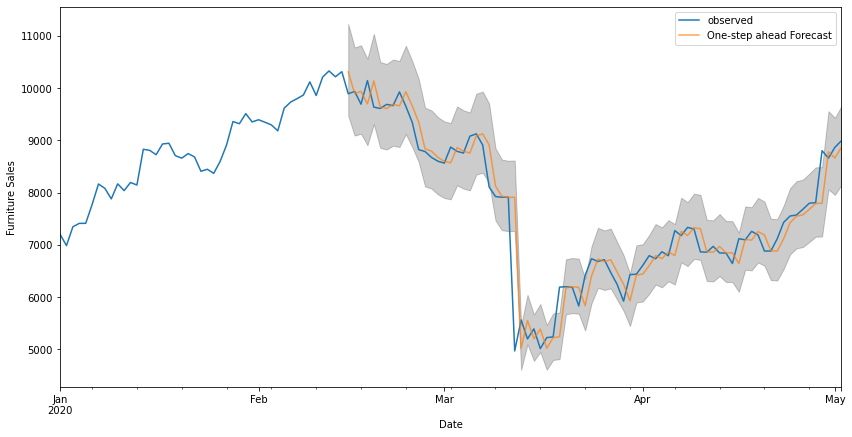

Mean Squared Error - 200856.87642754772
Root Mean Squared Error - 448.1705885347093


In [151]:
plot_sarimax_one_step(results, btc_log, "2020-02-15", date_trim="2020", inv_func=np.exp)

In [35]:
btc_log_train, btc_log_test = btc_log[:"2020-03-02"], btc_log["2020-03-03":]

In [31]:
pd.DataFrame(all_results, columns = ["ARIMA", "Season", "Error"]).sort_values("Error", ascending=True).reset_index(drop=True)

,ARIMA,Season,Error
0,"(1, 0, 1)","(0, 0, 0, 52)",0.271632
1,"(0, 1, 1)","(0, 0, 0, 52)",0.271732
2,"(0, 1, 1)","(0, 0, 1, 52)",0.272840
3,"(0, 1, 1)","(1, 0, 1, 52)",0.272845
4,"(0, 1, 1)","(1, 0, 0, 52)",0.272867
...,...,...,...
59,"(0, 0, 0)","(1, 1, 1, 52)",2.391090
60,"(0, 0, 1)","(0, 0, 0, 52)",3.706587
61,"(0, 0, 1)","(0, 0, 1, 52)",4.162421
62,"(0, 0, 0)","(0, 0, 1, 52)",4.978828


In [86]:
mod = sm.tsa.statespace.SARIMAX(btc_log_train,
                                order=(0, 1, 0),
                                seasonal_order=(0, 0, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0018    2.3e-05     78.112      0.000       0.002       0.002


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [43]:
btc_log_test

(61,)

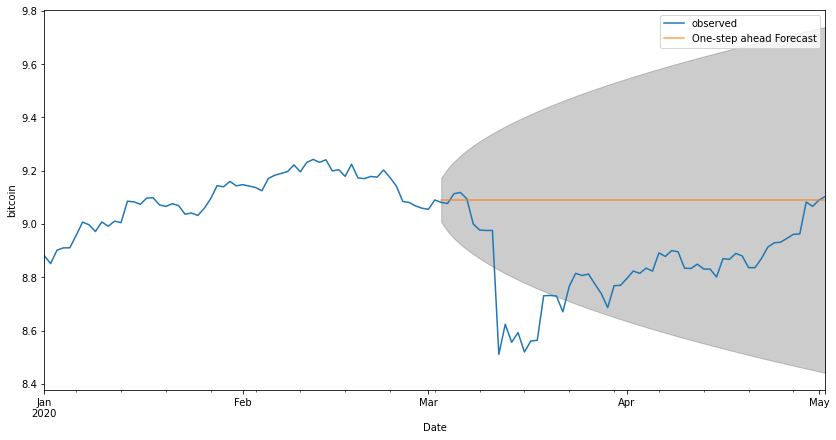

In [87]:
pred = results.get_prediction(start=pd.to_datetime('2020-03-03'), end=pd.to_datetime('2020-05-02'), dynamic=False)
pred_ci = pred.conf_int()
ax = btc_log["2020":].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('bitcoin')
plt.legend()
plt.show()

In [83]:
y_forecasted = np.exp(pred.predicted_mean)
y_truth = np.exp(btc_log_test)
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 6496069.59


In [72]:
y_truth

Date
2020-03-03    9.081119
2020-03-04    9.077409
2020-03-05    9.113693
2020-03-06    9.118505
2020-03-07    9.094924
                ...   
2020-04-28    8.962784
2020-04-29    9.082625
2020-04-30    9.066303
2020-05-01    9.089840
2020-05-02    9.103712
Name: Close, Length: 61, dtype: float64

In [ ]:
scaled_pipeline_2 = Pipeline([("scaler", StandardScaler()), ('SARIMAX', sm.tsa.statespace.SARIMAX())])

In [29]:
btc_train, btc_test = btc[:"2020-03-02"], btc["2020-03-03":]


In [ ]:
scaled_pipeline_1 = Pipeline([("scaler", StandardScaler()), ('SARIMAX', sm.tsa.statespace.SARIMAX())])

In [29]:
scaled_pipeline_1 = Pipeline([("log", FunctionTransformer(np.log1p, np.expm1), 'SARIMAX', sm.tsa.statespace.SARIMAX())])

In [167]:
df = pd.DataFrame(btc_log_train).reset_index()
df

,Date,Close
0,2013-04-28,4.899406
1,2013-04-29,4.973556
2,2013-04-30,4.934474
3,2013-05-01,4.762088
4,2013-05-02,4.655958
...,...,...
2496,2020-02-27,9.080743
2497,2020-02-28,9.067908
2498,2020-02-29,9.059461
2499,2020-03-01,9.055142


In [168]:
from fbprophet import Prophet
furniture = df
furniture = furniture.rename(columns={'Date': 'ds', 'Close': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [169]:
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='D')
furniture_forecast = furniture_model.predict(furniture_forecast)

<Figure size 1296x432 with 0 Axes>

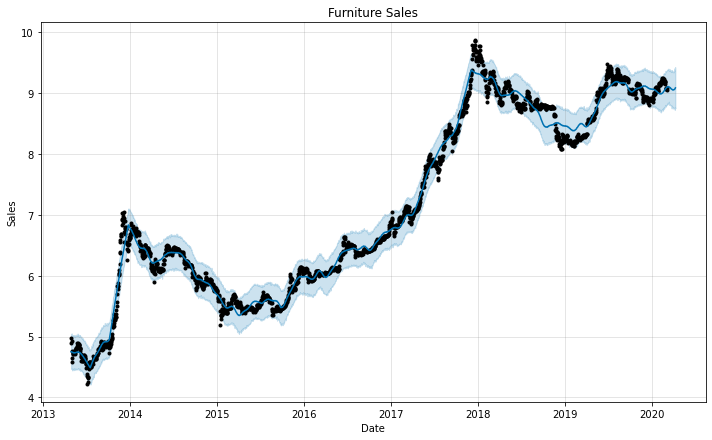

In [163]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

## LSTM

### One Month Forecast

In [5]:
btc_train, btc_test = btc[:"2020-04-04"], btc["2020-04-05":]

In [6]:
X, y = preprocess_lstm(btc_train)
X, y = X[["Close"]], y[["Close"]]

In [7]:
batch_size = 2
lstm_pipe = Pipeline([("scaler", MinMaxScaler()),
                      ("reshaper", LSTM_Reshaper()),
                      ('LSTM', Keras_Custom_Fitter(keras_model_wrapper,
                                                   l1_batch_input_shape=(batch_size, 1, X.shape[1]),
                                                   l1_neurons = 5, mod_lr = 0.0002,
                                                   epochs=2, batch_size=batch_size, shuffle=False))])

In [8]:
y_scale = MinMaxScaler()
y_scaled = y_scale.fit_transform(y)
pickle_dump(lstm_pipe, "models/base_model.pickle")
i = 0
rmse_list = []
while i < 500:
    lstm_pipe.fit(X, y_scaled)
    predictions = lstm_predictions(lstm_pipe, btc_train, ["Close"], max_predictions=30)
    lstm_pipe[2].model.save_weights(f"models/backup_weights{i}.h5")
    rmse = evaluate_intersection_loss(predictions, btc_test["Close"])
    rmse_list.append(rmse)
    i += 1

Train on 2532 samples
Epoch 1/2
2532/2532 [==============================] - 3s 1ms/sample - loss: 0.0039
Epoch 2/2
2532/2532 [==============================] - 2s 782us/sample - loss: 0.0029
MSE: 2967741.0172842056, RMSE: 1722.7132719301276)
Train on 2532 samples
Epoch 1/2
2532/2532 [==============================] - 3s 1ms/sample - loss: 0.0534
Epoch 2/2
2532/2532 [==============================] - 2s 791us/sample - loss: 0.0028
MSE: 1980270.9940349613, RMSE: 1407.2210181897374)
Train on 2532 samples
Epoch 1/2
2532/2532 [==============================] - 3s 1ms/sample - loss: 0.1700
Epoch 2/2
2532/2532 [==============================] - 2s 793us/sample - loss: 0.0028
MSE: 1429899.8006715553, RMSE: 1195.7841781323064)
Train on 2532 samples
Epoch 1/2
2532/2532 [==============================] - 3s 1ms/sample - loss: 0.0140
Epoch 2/2
2532/2532 [==============================] - 2s 793us/sample - loss: 0.0029
MSE: 3059109.8940880387, RMSE: 1749.0311301083348)
Train on 2532 samples
Epoch 

In [9]:
best_idx = rmse_list.index(min(rmse_list))
lstm_pipe[2].model.load_weights(f"models/backup_weights{best_idx}.h5")
predictions = lstm_predictions(lstm_pipe, btc_train, ["Close"], max_predictions=30)
evaluate_intersection_loss(predictions, btc_test["Close"])

MSE: 739909.1469594381, RMSE: 860.1797178261286)


860.1797178261286

In [10]:
import matplotlib.style as style
style.use('fivethirtyeight')

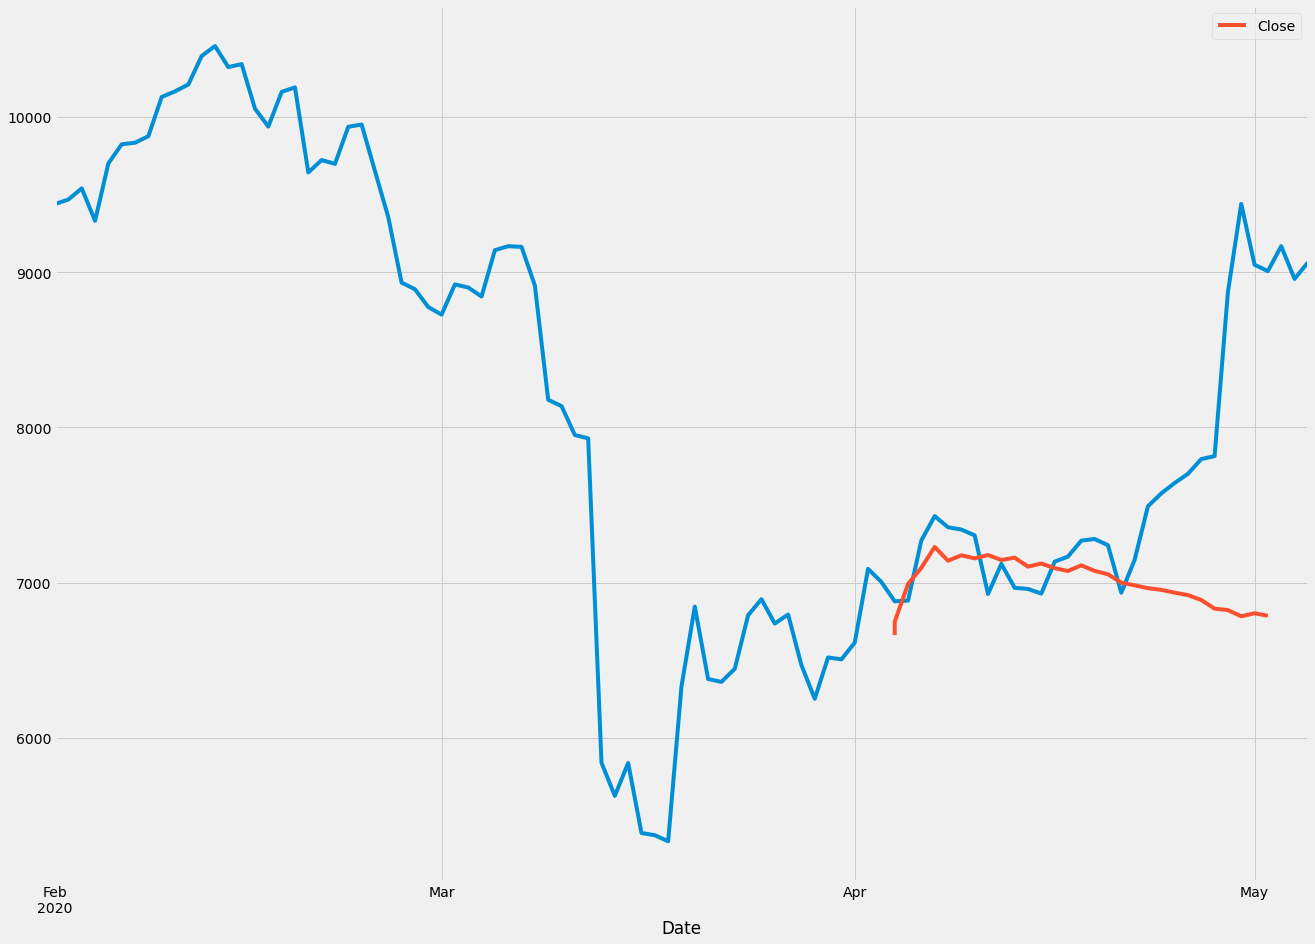

In [11]:
ax=btc["High"]["2020-02":].plot(figsize=(20,15))
# ax=btc_train["High"]["2020-02":].plot(figsize=(20,15))
# btc_test["High"].plot(figsize=(20,15), ax=ax)
predictions.plot(figsize=(20,15), ax=ax)

In [14]:
evaluate_intersection_loss(predictions[:"2020-04-22"], btc_test["Close"])

MSE: 46560.13613464948, RMSE: 215.77797879915707)


215.77797879915707

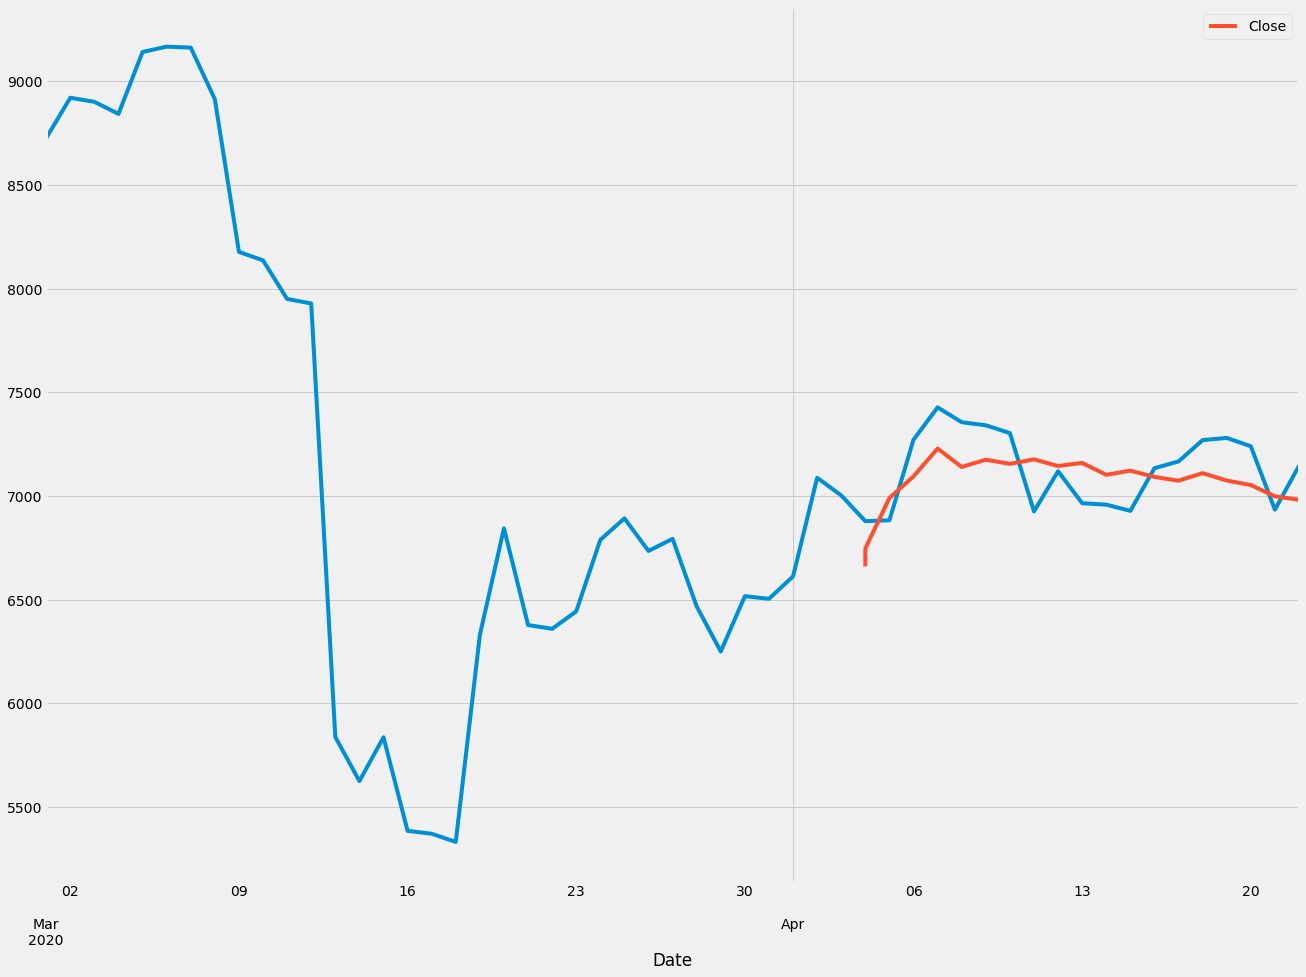

In [15]:
ax2=btc["High"]["2020-03":"2020-04-22"].plot(figsize=(20,15))
# ax=btc_train["High"]["2020-02":].plot(figsize=(20,15))
# btc_test["High"].plot(figsize=(20,15), ax=ax)
predictions[:"2020-04-22"].plot(figsize=(20,15), ax=ax2)

In [16]:
predictions_all = lstm_predictions(lstm_pipe, btc.iloc[1:], ["Close"], max_predictions=3000)

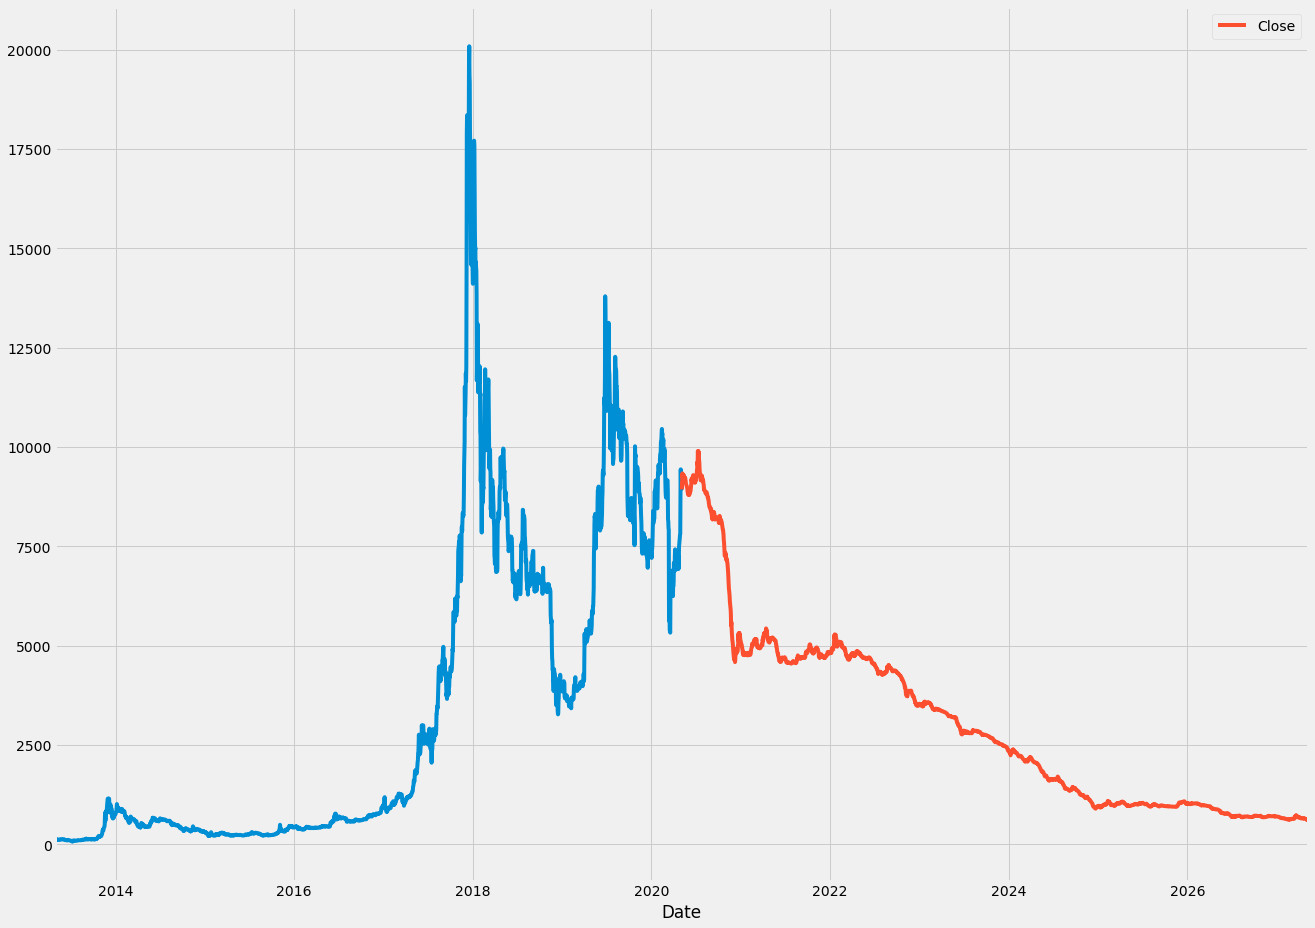

In [17]:
ax3=btc["High"].plot(figsize=(20,15))
# ax=btc_train["High"]["2020-02":].plot(figsize=(20,15))
# btc_test["High"].plot(figsize=(20,15), ax=ax)
predictions_all.plot(figsize=(20,15), ax=ax3)

### Factoring out the effects of Covid

In [25]:
btc_train, btc_test = btc[:"2020-02-14"], btc["2020-02-15":]

In [26]:
X, y = preprocess_lstm(btc_train)
X, y = X[["Close"]], y[["Close"]]

In [47]:
batch_size = 2
lstm_pipe = Pipeline([("scaler", MinMaxScaler()),
                      ("reshaper", LSTM_Reshaper()),
                      ('LSTM', Keras_Custom_Fitter(keras_model_wrapper,
                                                   l1_batch_input_shape=(batch_size, 1, X.shape[1]),
                                                   l1_neurons = 5, mod_lr = 0.00005,
                                                   epochs=2, batch_size=batch_size, shuffle=False))])

In [48]:
y_scale = MinMaxScaler()
y_scaled = y_scale.fit_transform(y)
pickle_dump(lstm_pipe, "models/base_model.pickle")
i = 0
rmse_list = []
while i < 500:
    lstm_pipe.fit(X, y_scaled)
    predictions = lstm_predictions(lstm_pipe, btc_train, ["Close"], max_predictions=80)
    lstm_pipe[2].model.save_weights(f"models/round4/backup_weights{i}.h5")
    rmse = evaluate_intersection_loss(predictions, btc_test["Close"])
    rmse_list.append(rmse)
    i += 1

Train on 2482 samples
Epoch 1/2
2482/2482 [==============================] - 3s 1ms/sample - loss: 0.0072
Epoch 2/2
2482/2482 [==============================] - 2s 804us/sample - loss: 0.0048
MSE: 5982732.000759163, RMSE: 2445.9623874375425)
Train on 2482 samples
Epoch 1/2
2482/2482 [==============================] - 3s 1ms/sample - loss: 0.0163
Epoch 2/2
2482/2482 [==============================] - 2s 798us/sample - loss: 0.0048
MSE: 5584906.770340503, RMSE: 2363.2407347412795)
Train on 2482 samples
Epoch 1/2
2482/2482 [==============================] - 3s 1ms/sample - loss: 0.0816
Epoch 2/2
2482/2482 [==============================] - 2s 801us/sample - loss: 0.0109
MSE: 2213937.9351920537, RMSE: 1487.9307561819044)
Train on 2482 samples
Epoch 1/2
2482/2482 [==============================] - 3s 1ms/sample - loss: 0.0056
Epoch 2/2
2482/2482 [==============================] - 2s 803us/sample - loss: 0.0049
MSE: 5777219.270581983, RMSE: 2403.5846709824855)
Train on 2482 samples
Epoch 1/2

In [25]:
rmse_list = []
for idx in range(0,100):
    lstm_pipe[2].model.load_weights(f"models/backup_weights{idx}.h5")
    predictions = lstm_predictions(lstm_pipe, btc_train, ["Close"], max_predictions=80)
    rmse = evaluate_intersection_loss(predictions, btc_test["Close"])
    rmse_list.append(rmse)

MSE: 38389796.27667977, RMSE: 6195.949989846575)
MSE: 10006977.963451862, RMSE: 3163.3807806604414)
MSE: 13257807.75249141, RMSE: 3641.127263979029)
MSE: 11153924.974915966, RMSE: 3339.7492383285257)
MSE: 10664986.790641183, RMSE: 3265.729136141144)
MSE: 13236020.013169294, RMSE: 3638.1341389741656)
MSE: 17390976.48550795, RMSE: 4170.248971645212)
MSE: 8439483.78653628, RMSE: 2905.078963907226)
MSE: 14147726.953073481, RMSE: 3761.346428218688)
MSE: 10293290.369338905, RMSE: 3208.3158150872405)
MSE: 10035188.556560485, RMSE: 3167.8365735246643)
MSE: 20708445.50211162, RMSE: 4550.653304978487)
MSE: 10798216.496496346, RMSE: 3286.06398241062)
MSE: 7730502.74828364, RMSE: 2780.378166416151)
MSE: 9966352.317888096, RMSE: 3156.953011669337)
MSE: 12118130.289724395, RMSE: 3481.110496626672)
MSE: 9428983.57257353, RMSE: 3070.6650049416867)
MSE: 12893487.528781677, RMSE: 3590.7502737981763)
MSE: 7877963.806454107, RMSE: 2806.771064132967)
MSE: 11291212.962607209, RMSE: 3360.2400156249564)
MSE: 

In [50]:
best_idx = rmse_list.index(min(rmse_list))
lstm_pipe[2].model.load_weights(f"models/round4/backup_weights{best_idx}.h5")
predictions = lstm_predictions(lstm_pipe, btc_train, ["Close"], max_predictions=80)
evaluate_intersection_loss(predictions, btc_test["Close"])

MSE: 2026597.433763883, RMSE: 1423.5861174385914)


1423.5861174385914

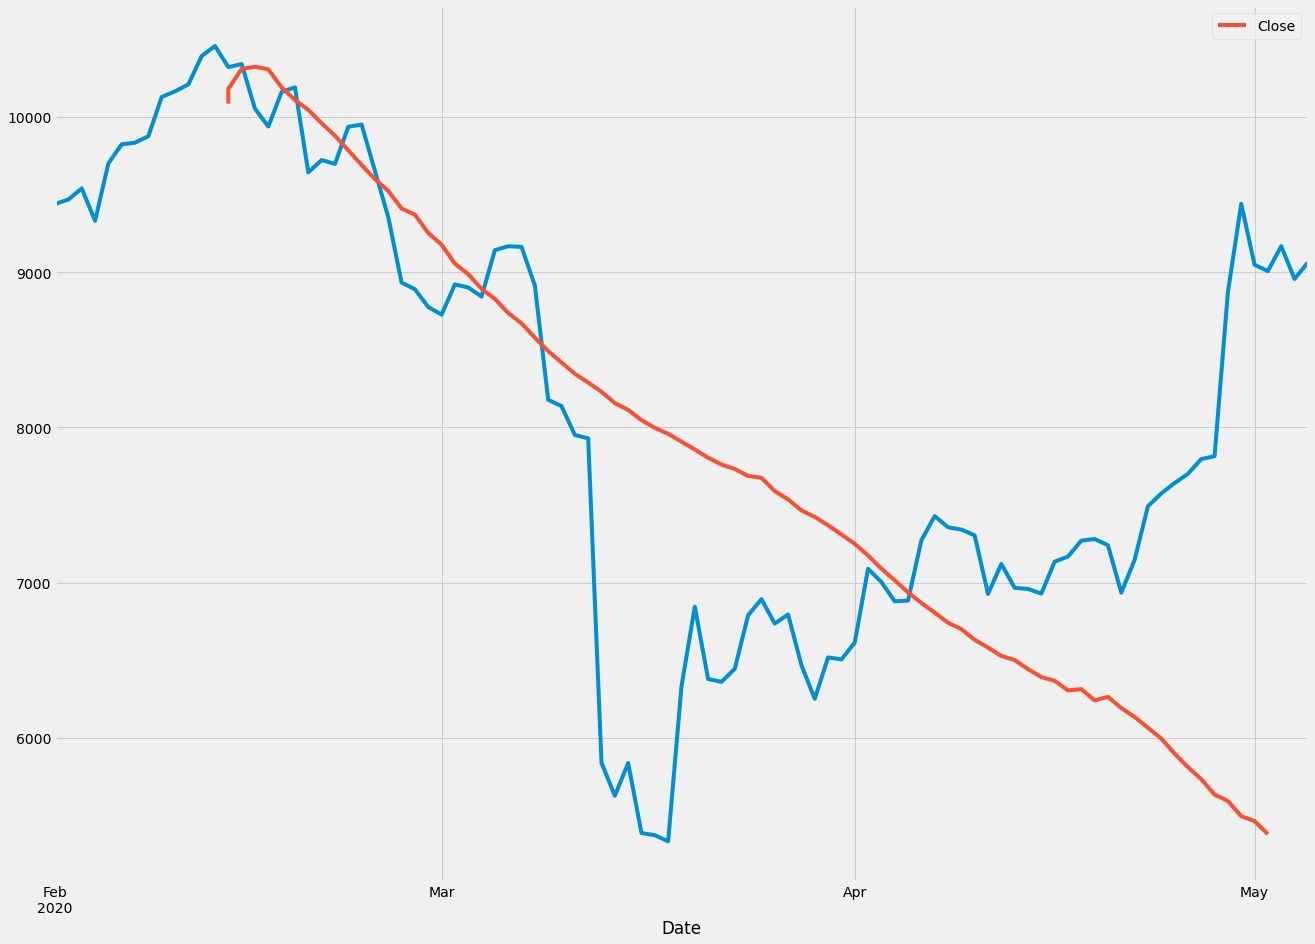

In [51]:
ax=btc["High"]["2020-02":].plot(figsize=(20,15))
# ax=btc_train["High"]["2020-02":].plot(figsize=(20,15))
# btc_test["High"].plot(figsize=(20,15), ax=ax)
predictions.plot(figsize=(20,15), ax=ax)

In [63]:
test = btc.diff(1).iloc[1:]

In [64]:
btc

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,NaN,1500520000
2013-04-29,134.44,147.49,134.00,144.54,NaN,1491160000
2013-04-30,144.00,146.93,134.05,139.00,NaN,1597780000
2013-05-01,139.00,139.89,107.72,116.99,NaN,1542820000
2013-05-02,116.38,125.60,92.28,105.21,NaN,1292190000
...,...,...,...,...,...,...
2020-05-01,8672.78,9048.02,8667.76,8864.77,4.406839e+10,162722652380
2020-05-02,8869.06,9007.19,8811.37,8988.60,4.013439e+10,165012307600
2020-05-03,8983.61,9167.78,8830.97,8897.47,4.710179e+10,163358189151


In [70]:
test+btc.shift(1)

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-28,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,134.44,147.49,134.00,144.54,NaN,1.491160e+09
2013-04-30,144.00,146.93,134.05,139.00,NaN,1.597780e+09
2013-05-01,139.00,139.89,107.72,116.99,NaN,1.542820e+09
2013-05-02,116.38,125.60,92.28,105.21,NaN,1.292190e+09
...,...,...,...,...,...,...
2020-05-01,8672.78,9048.02,8667.76,8864.77,4.406839e+10,1.627227e+11
2020-05-02,8869.06,9007.19,8811.37,8988.60,4.013439e+10,1.650123e+11
2020-05-03,8983.61,9167.78,8830.97,8897.47,4.710179e+10,1.633582e+11


In [72]:
lstm_predictions(lstm_pipe, btc_train, ["Close"], max_predictions=80)

Close   -0.010873
Name: 2020-02-13 00:00:00, dtype: float64
Close    9.241075
Name: 2020-02-14 00:00:00, dtype: float64


,Close
2020-02-15,10243.621025
2020-02-16,10413.601694
2020-02-17,10613.115046
2020-02-18,10880.110497
2020-02-19,11044.045482
...,...
2020-04-30,12335.788624
2020-05-01,12443.244955
2020-05-02,12201.693728
2020-05-03,12343.681978
